In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Vermont

## Load VEST File

In [2]:
vest_vt_18 = gp.read_file("./raw-from-source/VEST/vt_2018/vt_2018.shp")

## Election Results

### VEST Documentation

Election results from the Vermont Secretary of State (https://vtelectionarchive.sec.state.vt.us/)
Shapefile from intersecting the Census county subdivision and State House maps.

Vermont has four unorganized towns whose residents cast votes in neighboring towns. These were distributed back based on voting age population in the 2017 American Community Survey as 2018 ACS estimates are not available at the township level. (Averill-Canaan, Buels Gore-Huntington, Ferdinand-Brighton, Glastenbury-Shaftsbury.)

### Load Source Files

In [3]:
all_files = os.listdir("./raw-from-source/Election_Results/")
li = []
for file in all_files:
    print(file)
    ref = "./raw-from-source/Election_Results/"
    file_ref = ref+file
    file_prev = pd.read_csv(file_ref,engine='python',index_col=None)
    #Only keep the City/Town and Pct columns in one file, as they are duplicated
    #Delete unused columns in others
    if file != 'VT_Elections_Database__2018_Secretary_of_State_General_Election_including_precincts.csv':
        print(file)
        file_prev = file_prev.drop(['City/Town', 'Ward', 'Pct','Blanks', 'Spoiled','Total Votes Cast'], axis=1)
        file_prev = file_prev.drop([0])
    else:
        file_prev = file_prev.drop(['Ward','Blanks', 'Spoiled','Total Votes Cast'], axis=1)
        file_prev = file_prev.drop([0])
    li.append(file_prev)
    
#Define the dataframe, note we are add the loaded dataframes next to one another and not below
frame = pd.concat(li, axis=1, ignore_index=False)

VT_Elections_Database__2018_Secretary_of_State_General_Election_including_precincts.csv
VT_Elections_Database__2018_Lieutenant_Governor_General_Election_including_precincts.csv
VT_Elections_Database__2018_Lieutenant_Governor_General_Election_including_precincts.csv
VT_Elections_Database__2018_Governor_General_Election_including_precincts.csv
VT_Elections_Database__2018_Governor_General_Election_including_precincts.csv
VT_Elections_Database__2018_Treasurer_General_Election_including_precincts.csv
VT_Elections_Database__2018_Treasurer_General_Election_including_precincts.csv
VT_Elections_Database__2018_Auditor_General_Election_including_precincts.csv
VT_Elections_Database__2018_Auditor_General_Election_including_precincts.csv
VT_Elections_Database__2018_Attorney_General_General_Election_including_precincts.csv
VT_Elections_Database__2018_Attorney_General_General_Election_including_precincts.csv
VT_Elections_Database__2018_U_S_House_General_Election_including_precincts.csv
VT_Elections_Da

### Clean up the election results

#### Rename and reorder the columns to match VEST

In [4]:
print(frame.columns)

Index(['City/Town', 'Pct', 'Jim Condos', 'H. Brooke Paige',
       'Mary Alice Herbert', 'Write-Ins', 'David Zuckerman', 'Don Turner, Jr',
       'Murray Ngoima', 'Write-Ins', 'Phil Scott', 'Christine Hallquist',
       'Trevor Barlow', 'Charles E. Laramie', 'Cris Ericson', 'Stephen Marx',
       'Emily Peyton', 'Write-Ins', 'Beth Pearce', 'Richard Morton',
       'Write-Ins', 'Doug Hoffer', 'Richard Kenyon', 'Marina Brown',
       'Write-Ins', 'T.J. Donovan', 'Janssen Willhoit', 'Rosemarie Jackowski',
       'Write-Ins', 'Peter Welch', 'Anya Tynio', 'Cris Ericson',
       'Laura S. Potter', 'Write-Ins', 'Bernie Sanders', 'Lawrence Zupan',
       'Brad J. Peacock', 'Russell Beste', 'Edward S. Gilbert, Jr',
       'Folasade Adeluola', 'Reid Kane', 'Jon Svitavsky', 'Bruce Busa',
       'Write-Ins'],
      dtype='object')


In [5]:
print(frame.columns)

#Renaming the columns to match VEST
frame.columns = ['NAMELSAD', 'NAMELSAD_1', 'G18SOSDCON', 'G18SOSRPAI',
                'G18SOSOHEB','G18SOSOWRI','G18LTGPZUC','G18LTGRTUR',
                'G18LTGONGO','G18LTGOWRI','G18GOVRSCO','G18GOVDHAL',
                'G18GOVIBAR','G18GOVILAR','G18GOVIERI','G18GOVOMAR',
                'G18GOVOPEY','G18GOVOWRI','G18TREDPEA','G18TRERMOR',
                'G18TREOWRI','G18AUDDHOF','G18AUDRKEN','G18AUDOBRO',
                'G18AUDOWRI','G18ATGDDON','G18ATGRWIL','G18ATGOJAC',
                'G18ATGOWRI','G18HALDWEL','G18HALRTYN','G18HALIERI',
                'G18HALOPOT','G18HALOWRI','G18USSISAN','G18USSRZUP',
                'G18USSIPEA','G18USSIBES','G18USSIGIL',
                'G18USSIADE','G18USSOKAN','G18USSISVI','G18USSIBUS',
                'G18USSOWRI']

#Reordering the columns to match VEST
frame = frame[['NAMELSAD', 'NAMELSAD_1',
       'G18USSISAN', 'G18USSRZUP', 'G18USSIPEA', 'G18USSIBES', 'G18USSIGIL',
       'G18USSIADE', 'G18USSISVI', 'G18USSIBUS', 'G18USSOKAN', 'G18USSOWRI',
       'G18HALDWEL', 'G18HALRTYN', 'G18HALIERI', 'G18HALOPOT', 'G18HALOWRI',
       'G18GOVDHAL', 'G18GOVRSCO', 'G18GOVIBAR', 'G18GOVILAR', 'G18GOVIERI',
       'G18GOVOMAR', 'G18GOVOPEY', 'G18GOVOWRI', 'G18LTGPZUC', 'G18LTGRTUR',
       'G18LTGONGO', 'G18LTGOWRI', 'G18ATGDDON', 'G18ATGRWIL', 'G18ATGOJAC',
       'G18ATGOWRI', 'G18SOSDCON', 'G18SOSRPAI', 'G18SOSOHEB', 'G18SOSOWRI',
       'G18TREDPEA', 'G18TRERMOR', 'G18TREOWRI', 'G18AUDDHOF', 'G18AUDRKEN',
       'G18AUDOBRO', 'G18AUDOWRI']]

Index(['City/Town', 'Pct', 'Jim Condos', 'H. Brooke Paige',
       'Mary Alice Herbert', 'Write-Ins', 'David Zuckerman', 'Don Turner, Jr',
       'Murray Ngoima', 'Write-Ins', 'Phil Scott', 'Christine Hallquist',
       'Trevor Barlow', 'Charles E. Laramie', 'Cris Ericson', 'Stephen Marx',
       'Emily Peyton', 'Write-Ins', 'Beth Pearce', 'Richard Morton',
       'Write-Ins', 'Doug Hoffer', 'Richard Kenyon', 'Marina Brown',
       'Write-Ins', 'T.J. Donovan', 'Janssen Willhoit', 'Rosemarie Jackowski',
       'Write-Ins', 'Peter Welch', 'Anya Tynio', 'Cris Ericson',
       'Laura S. Potter', 'Write-Ins', 'Bernie Sanders', 'Lawrence Zupan',
       'Brad J. Peacock', 'Russell Beste', 'Edward S. Gilbert, Jr',
       'Folasade Adeluola', 'Reid Kane', 'Jon Svitavsky', 'Bruce Busa',
       'Write-Ins'],
      dtype='object')


#### Clean the column data types

In [6]:
data_columns = ['G18SOSDCON', 'G18SOSRPAI', 'G18SOSOHEB',
       'G18SOSOWRI', 'G18LTGPZUC', 'G18LTGRTUR', 'G18LTGONGO', 'G18LTGOWRI',
       'G18GOVRSCO', 'G18GOVDHAL', 'G18GOVIBAR', 'G18GOVILAR', 'G18GOVIERI',
       'G18GOVOMAR', 'G18GOVOPEY', 'G18GOVOWRI', 'G18TREDPEA', 'G18TRERMOR',
       'G18TREOWRI', 'G18AUDDHOF', 'G18AUDRKEN', 'G18AUDOBRO', 'G18AUDOWRI',
       'G18ATGDDON', 'G18ATGRWIL', 'G18ATGOJAC', 'G18ATGOWRI', 'G18HALDWEL',
       'G18HALRTYN', 'G18HALIERI', 'G18HALOPOT', 'G18HALOWRI', 'G18USSISAN',
       'G18USSRZUP', 'G18USSIPEA', 'G18USSIBES', 'G18USSIGIL', 'G18USSIADE',
       'G18USSOKAN', 'G18USSISVI', 'G18USSIBUS', 'G18USSOWRI']

#Some of the columns include commas to represent numbers in the thousands, this code cleans those
for race in data_columns:
    frame[race]=frame[race].astype(str)
    frame[race]=frame[race].apply(lambda x: x.replace(',',''))
    frame[race]=frame[race].astype(float)
    frame[race]=frame[race].astype(int)

#### Remove rows that count total votes

In [7]:
frame = frame[frame['NAMELSAD']!="TOTALS"]

#### Compare race-wide election totals against VEST

In [8]:
print("Races with differences will be printed below:")
for race in data_columns:
    if (sum(vest_vt_18[race])-sum(frame[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_vt_18[race])-sum(frame[race]))+" votes")
        print("\tVEST: "+str(sum(vest_vt_18[race]))+" votes")
        print("\tSOURCES: "+str(sum(frame[race]))+" votes")
print("")
print("All other races are equal")

Races with differences will be printed below:

All other races are equal


### Following VEST documentation, allocate votes to the four unorganized towns

#### Documentation

> Vermont has four unorganized towns whose residents cast votes in neighboring towns. These were distributed back based on voting age population in the 2017 American Community Survey as 2018 ACS estimates are not available at the township level. (Averill-Canaan, Buels Gore-Huntington, Ferdinand-Brighton, Glastenbury-Shaftsbury.)

#### Add empty precincts to the dataframe (will allocate votes afterwards)

In [9]:
new_df = pd.DataFrame([["Averill","",    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Buels Gore","", 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Ferdinand","",  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Glastenbury","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                      ,columns=frame.columns)
frame = frame.append(new_df)
frame.reset_index(inplace=True,drop=True)

#### Load the ACS data

In [10]:
acs_allocating_votes = pd.read_csv("./raw-from-source/ACS/Allocating_Votes/ACSST5Y2017.S0101_2021-05-24T111612/ACSST5Y2017.S0101_data_with_overlays_2021-05-24T111609.csv")        

In [11]:
#Clean up the header
acs_allocating_votes.columns = acs_allocating_votes.iloc[0]
acs_allocating_votes = acs_allocating_votes.drop([0])

#Grab needed columns
acs_allocating_votes = acs_allocating_votes[["Geographic Area Name",'Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over']]

#Rename columns
acs_allocating_votes.columns=["Place","VAP Estimate"]

#Clean columns
acs_allocating_votes["VAP Estimate"]=acs_allocating_votes["VAP Estimate"].astype(float)

#Define a "ratio" column, fill it below with the percentage of voters from the area where votes were counted
acs_allocating_votes["ratio"]=0

In [12]:
print(acs_allocating_votes)

                                          Place  VAP Estimate  ratio
1  Glastenbury town, Bennington County, Vermont           7.0      0
2   Shaftsbury town, Bennington County, Vermont        2632.0      0
3        Buels gore, Chittenden County, Vermont          21.0      0
4   Huntington town, Chittenden County, Vermont        1521.0      0
5           Averill town, Essex County, Vermont          21.0      0
6          Brighton town, Essex County, Vermont         930.0      0
7            Canaan town, Essex County, Vermont         800.0      0
8         Ferdinand town, Essex County, Vermont           3.0      0


In [13]:
#Glastenbury (from Shaftsbury)
acs_allocating_votes.iloc[0,2]=acs_allocating_votes.iloc[0,1]/acs_allocating_votes.iloc[1,1]
#Buels (from Huntington)
acs_allocating_votes.iloc[2,2]=acs_allocating_votes.iloc[2,1]/acs_allocating_votes.iloc[3,1]
#Averill (from Canaan)
acs_allocating_votes.iloc[4,2]=acs_allocating_votes.iloc[4,1]/acs_allocating_votes.iloc[6,1]
#Ferdinand (from Brighton)
acs_allocating_votes.iloc[7,2]=acs_allocating_votes.iloc[7,1]/acs_allocating_votes.iloc[5,1]

print(acs_allocating_votes)

                                          Place  VAP Estimate     ratio
1  Glastenbury town, Bennington County, Vermont           7.0  0.002660
2   Shaftsbury town, Bennington County, Vermont        2632.0  0.000000
3        Buels gore, Chittenden County, Vermont          21.0  0.013807
4   Huntington town, Chittenden County, Vermont        1521.0  0.000000
5           Averill town, Essex County, Vermont          21.0  0.026250
6          Brighton town, Essex County, Vermont         930.0  0.000000
7            Canaan town, Essex County, Vermont         800.0  0.000000
8         Ferdinand town, Essex County, Vermont           3.0  0.003226


#### Allocate votes to Averill from Canaan

In [14]:
for race in data_columns:
    frame.loc[frame["NAMELSAD"]=="Averill",race] = round(frame.loc[frame["NAMELSAD"]=="Canaan",race].values[0]*0.026250,0).astype(int)
    frame.loc[frame["NAMELSAD"]=="Canaan",race]= round(frame.loc[frame["NAMELSAD"]=="Canaan",race].values[0]*(1-0.026250),0).astype(int)
print(frame.loc[frame["NAMELSAD"]=="Averill"])
print(frame.loc[frame["NAMELSAD"]=="Canaan"])

    NAMELSAD NAMELSAD_1  G18USSISAN  G18USSRZUP  G18USSIPEA  G18USSIBES  \
275  Averill                      5           3           0           0   

     G18USSIGIL  G18USSIADE  G18USSISVI  G18USSIBUS  ...  G18SOSRPAI  \
275           0           0           0           0  ...           4   

     G18SOSOHEB  G18SOSOWRI  G18TREDPEA  G18TRERMOR  G18TREOWRI  G18AUDDHOF  \
275           0           0           4           4           0           3   

     G18AUDRKEN  G18AUDOBRO  G18AUDOWRI  
275           4           1           0  

[1 rows x 44 columns]
   NAMELSAD NAMELSAD_1  G18USSISAN  G18USSRZUP  G18USSIPEA  G18USSIBES  \
47   Canaan        NaN         179         114           3           5   

    G18USSIGIL  G18USSIADE  G18USSISVI  G18USSIBUS  ...  G18SOSRPAI  \
47           4           6           0           2  ...         137   

    G18SOSOHEB  G18SOSOWRI  G18TREDPEA  G18TRERMOR  G18TREOWRI  G18AUDDHOF  \
47           4           1         151         147           0      

#### Allocate votes to Buels Gore from Huntington

In [15]:
frame.loc[frame["NAMELSAD"]=="Huntington"]

for race in data_columns:
    frame.loc[frame["NAMELSAD"]=="Buels Gore",race] = round(frame.loc[frame["NAMELSAD"]=="Huntington",race].values[0]*0.013807,0).astype(int)
    frame.loc[frame["NAMELSAD"]=="Huntington",race]= round(frame.loc[frame["NAMELSAD"]=="Huntington",race].values[0]*(1-0.013807),0).astype(int)
print(frame.loc[frame["NAMELSAD"]=="Buels Gore"])
print(frame.loc[frame["NAMELSAD"]=="Huntington"])

       NAMELSAD NAMELSAD_1  G18USSISAN  G18USSRZUP  G18USSIPEA  G18USSIBES  \
276  Buels Gore                     12           3           0           0   

     G18USSIGIL  G18USSIADE  G18USSISVI  G18USSIBUS  ...  G18SOSRPAI  \
276           0           0           0           0  ...           3   

     G18SOSOHEB  G18SOSOWRI  G18TREDPEA  G18TRERMOR  G18TREOWRI  G18AUDDHOF  \
276           0           0          12           3           0          11   

     G18AUDRKEN  G18AUDOBRO  G18AUDOWRI  
276           3           0           0  

[1 rows x 44 columns]
       NAMELSAD NAMELSAD_1  G18USSISAN  G18USSRZUP  G18USSIPEA  G18USSIBES  \
108  Huntington        NaN         855         202           4           9   

     G18USSIGIL  G18USSIADE  G18USSISVI  G18USSIBUS  ...  G18SOSRPAI  \
108           7           6           3           3  ...         211   

     G18SOSOHEB  G18SOSOWRI  G18TREDPEA  G18TRERMOR  G18TREOWRI  G18AUDDHOF  \
108          30           0         838         217

#### Allocate votes to Ferdinand from Brighton

In [16]:
for race in data_columns:
    frame.loc[frame["NAMELSAD"]=="Ferdinand",race] = round(frame.loc[frame["NAMELSAD"]=="Brighton",race].values[0]*0.003226,0).astype(int)
    frame.loc[frame["NAMELSAD"]=="Brighton",race]= round(frame.loc[frame["NAMELSAD"]=="Brighton",race].values[0]*(1-0.003226),0).astype(int)
print(frame.loc[frame["NAMELSAD"]=="Ferdinand"])
print(frame.loc[frame["NAMELSAD"]=="Brighton"])

      NAMELSAD NAMELSAD_1  G18USSISAN  G18USSRZUP  G18USSIPEA  G18USSIBES  \
277  Ferdinand                      1           1           0           0   

     G18USSIGIL  G18USSIADE  G18USSISVI  G18USSIBUS  ...  G18SOSRPAI  \
277           0           0           0           0  ...           1   

     G18SOSOHEB  G18SOSOWRI  G18TREDPEA  G18TRERMOR  G18TREOWRI  G18AUDDHOF  \
277           0           0           1           1           0           1   

     G18AUDRKEN  G18AUDOBRO  G18AUDOWRI  
277           1           0           0  

[1 rows x 44 columns]
    NAMELSAD NAMELSAD_1  G18USSISAN  G18USSRZUP  G18USSIPEA  G18USSIBES  \
30  Brighton        NaN         234         181           2           3   

    G18USSIGIL  G18USSIADE  G18USSISVI  G18USSIBUS  ...  G18SOSRPAI  \
30           7           6           3           2  ...         210   

    G18SOSOHEB  G18SOSOWRI  G18TREDPEA  G18TRERMOR  G18TREOWRI  G18AUDDHOF  \
30          16           0         224         215           0

#### Allocate votes to Glastenbury from Shaftsbury

In [17]:
for race in data_columns:
    frame.loc[frame["NAMELSAD"]=="Glastenbury",race] = round(frame.loc[frame["NAMELSAD"]=="Shaftsbury",race].values[0]*0.002660,0).astype(int)
    frame.loc[frame["NAMELSAD"]=="Shaftsbury",race]= round(frame.loc[frame["NAMELSAD"]=="Shaftsbury",race].values[0]*(1-0.002660),0).astype(int)
print(frame.loc[frame["NAMELSAD"]=="Glastenbury"])
print(frame.loc[frame["NAMELSAD"]=="Shaftsbury"])

        NAMELSAD NAMELSAD_1  G18USSISAN  G18USSRZUP  G18USSIPEA  G18USSIBES  \
278  Glastenbury                      2           1           1           0   

     G18USSIGIL  G18USSIADE  G18USSISVI  G18USSIBUS  ...  G18SOSRPAI  \
278           0           0           0           0  ...           1   

     G18SOSOHEB  G18SOSOWRI  G18TREDPEA  G18TRERMOR  G18TREOWRI  G18AUDDHOF  \
278           0           0           2           2           0           2   

     G18AUDRKEN  G18AUDOBRO  G18AUDOWRI  
278           2           0           0  

[1 rows x 44 columns]
       NAMELSAD NAMELSAD_1  G18USSISAN  G18USSRZUP  G18USSIPEA  G18USSIBES  \
191  Shaftsbury        NaN         840         408         340          10   

     G18USSIGIL  G18USSIADE  G18USSISVI  G18USSIBUS  ...  G18SOSRPAI  \
191           2           0           4           4  ...         535   

     G18SOSOHEB  G18SOSOWRI  G18TREDPEA  G18TRERMOR  G18TREOWRI  G18AUDDHOF  \
191          76           1         932         6

#### Compare race-wide election totals against VEST to make sure totals still match

In [18]:
for race in data_columns:
    if (sum(vest_vt_18[race])-sum(frame[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_vt_18[race])-sum(frame[race]))+" votes")
        print("\tVEST: "+str(sum(vest_vt_18[race]))+" votes")
        print("\tSOURCES: "+str(sum(frame[race]))+" votes")
print("")
print("All races are equal")


All races are equal


#### Compare county-by-county election totals against VEST (see below)

The election results file does not contain county information, but the shapefile information does, so this will be calculated after joining election results to the shapefile.

#### Compare precinct-by-precinct election results against VEST (see below)

Given the smallness of the file, this will be calculated after joining the election results to the shapefile

## Shapefiles

### VEST Documentation

Shapefile from intersecting the Census county subdivision and State House maps.

### Plot VEST

<AxesSubplot:>

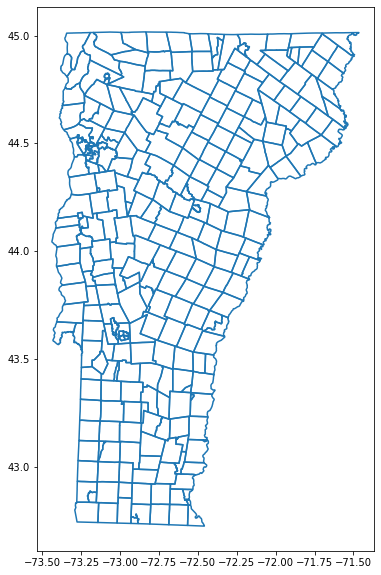

In [19]:
vest_vt_18.boundary.plot(figsize=(10,10))

### Import State District File

In [20]:
state_distr = gp.read_file("./raw-from-source/Shapefiles/VT_Data_-_Vermont_House_Districts_2012/VT_Data_-_Vermont_House_Districts_2012.shp")

#Grab needed columns
state_distr = state_distr[['DISTRICT','NAME','geometry']]

#Modify CRS
state_distr=state_distr.to_crs(vest_vt_18.crs)

In [21]:
county_sub = gp.read_file("./raw-from-source/Shapefiles/VT_2010_Census_County_Subdivision_Boundaries_and_Statistics/VT_2010_Census_County_Subdivision_Boundaries_and_Statistics.shp")

#Grab columns
county_sub = county_sub[['COUNTYFP10','NAME10', 'NAMELSAD10','geometry']]

#Modify CRS
county_sub=county_sub.to_crs(vest_vt_18.crs)

<AxesSubplot:>

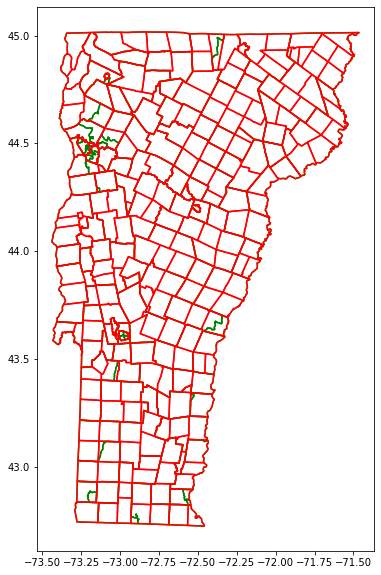

In [22]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = state_distr.boundary.plot(figsize=(10,10),color="green")
county_sub.boundary.plot(figsize=(10,10),ax=ax,color="red")

### Perform the shapefile computation and check the # of rows (looking for 284)

In [23]:
fig = gp.overlay(county_sub, state_distr, how="identity")
fig = fig.to_crs(vest_vt_18.crs)
print(fig.shape)

(284, 6)


<ipython-input-23-293e6f34c7b2>:1: UserWarning: `keep_geom_type=True` in overlay resulted in 696 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  fig = gp.overlay(county_sub, state_distr, how="identity")


### Compare to VEST file

<AxesSubplot:>

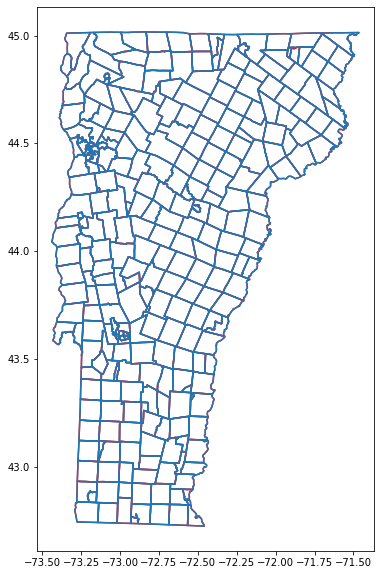

In [24]:
ax_2 = fig.boundary.plot(figsize=(10,10),color="red")
vest_vt_18.boundary.plot(figsize=(10,10),ax=ax_2)

## Join Election Results to Shapefile

### Matching Names

In [25]:
#Check number of rows and try to find a unique ID for each

print(fig.shape)
print(len((fig["NAMELSAD10"]+fig["DISTRICT"]).unique()))
print(frame.shape)
print(frame.columns)
print(len((frame["NAMELSAD"]+frame["NAMELSAD_1"].astype(str)).unique()))

#As you'll notice, there are 5 fewer election result columns

(284, 6)
284
(279, 44)
Index(['NAMELSAD', 'NAMELSAD_1', 'G18USSISAN', 'G18USSRZUP', 'G18USSIPEA',
       'G18USSIBES', 'G18USSIGIL', 'G18USSIADE', 'G18USSISVI', 'G18USSIBUS',
       'G18USSOKAN', 'G18USSOWRI', 'G18HALDWEL', 'G18HALRTYN', 'G18HALIERI',
       'G18HALOPOT', 'G18HALOWRI', 'G18GOVDHAL', 'G18GOVRSCO', 'G18GOVIBAR',
       'G18GOVILAR', 'G18GOVIERI', 'G18GOVOMAR', 'G18GOVOPEY', 'G18GOVOWRI',
       'G18LTGPZUC', 'G18LTGRTUR', 'G18LTGONGO', 'G18LTGOWRI', 'G18ATGDDON',
       'G18ATGRWIL', 'G18ATGOJAC', 'G18ATGOWRI', 'G18SOSDCON', 'G18SOSRPAI',
       'G18SOSOHEB', 'G18SOSOWRI', 'G18TREDPEA', 'G18TRERMOR', 'G18TREOWRI',
       'G18AUDDHOF', 'G18AUDRKEN', 'G18AUDOBRO', 'G18AUDOWRI'],
      dtype='object')
279


In [26]:
fig["join_col"]=fig["NAMELSAD10"]+"-"+fig["DISTRICT"]
frame["NAMELSAD_1"]=frame["NAMELSAD_1"].fillna("")
frame["join_col"]=frame["NAMELSAD"]+"-"+frame["NAMELSAD_1"].astype(str)

In [27]:
frame["join_col"].to_csv("./election_unique_ID.csv")
fig["join_col"].to_csv("./shapefile_unique_ID.csv")

### Change the names to match (look through dictionary to see typical string differences)

In [28]:
name_changes_dict = {'Addison-': 'Addison town-ADD-3', 'Albany-': 'Albany town-ORL-CAL', 'Alburgh-': 'Alburg town-GI-CHI', 'Andover-': 'Andover town-WDR-3-1', 'Arlington-': 'Arlington town-BEN-4', 'Athens-': 'Athens town-WDH-3', 'Averill-': 'Averill town-ESX-CAL-ORL', 'Bakersfield-': 'Bakersfield town-FRA-6', 'Baltimore-': 'Baltimore town-WDR-3-1', 'Barnard-': 'Barnard town-WDR-4-1', 'Barnet-': 'Barnet town-CAL-1', 'Barre City-': 'Barre city-WAS-3', 'Barre Town-': 'Barre town-WAS-2', 'Barton-': 'Barton town-ORL-CAL', 'Belvidere-': 'Belvidere town-LAM-2', 'Bennington-Bennington 2-1': 'Bennington town-BEN-2-1', 'Bennington-Bennington 2-2': 'Bennington town-BEN-2-2', 'Benson-': 'Benson town-ADD-RUT', 'Berkshire-': 'Berkshire town-FRA-5', 'Berlin-': 'Berlin town-WAS-1', 'Bethel-': 'Bethel town-WDR-RUT', 'Bloomfield-': 'Bloomfield town-ESX-CAL-ORL', 'Bolton-': 'Bolton town-WAS-CHI', 'Bradford-': 'Bradford town-ORA-2', 'Braintree-': 'Braintree town-ORA-WAS-ADD', 'Brandon-': 'Brandon town-RUT-6', 'Brattleboro-Windham 2-1': 'Brattleboro town-WDH-2-1', 'Brattleboro-Windham 2-2': 'Brattleboro town-WDH-2-2', 'Brattleboro-Windham 2-3': 'Brattleboro town-WDH-2-3', 'Bridgewater-': 'Bridgewater town-RUT-WDR-1', 'Bridport-': 'Bridport town-ADD-5', 'Brighton-': 'Brighton town-ESX-CAL-ORL', 'Bristol-': 'Bristol town-ADD-4', 'Brookfield-': 'Brookfield town-ORA-WAS-ADD', 'Brookline-': 'Brookline town-WDH-3', 'Brownington-': 'Brownington town-ORL-1', 'Brunswick-': 'Brunswick town-ESX-CAL', 'Buels Gore-': 'Buels gore-WAS-CHI', 'Burke-': 'Burke town-CAL-4', 'Burlington-Chittenden 6-1': 'Burlington city-CHI-6-1', 'Burlington-Chittenden 6-2': 'Burlington city-CHI-6-2', 'Burlington-Chittenden 6-3': 'Burlington city-CHI-6-3', 'Burlington-Chittenden 6-4': 'Burlington city-CHI-6-4', 'Burlington-Chittenden 6-5': 'Burlington city-CHI-6-5', 'Burlington-Chittenden 6-6': 'Burlington city-CHI-6-6', 'Burlington-Chittenden 6-7': 'Burlington city-CHI-6-7', 'Cabot-': 'Cabot town-CAL-WAS', 'Calais-': 'Calais town-WAS-6', 'Cambridge-': 'Cambridge town-LAM-3', 'Canaan-': 'Canaan town-ESX-CAL-ORL', 'Castleton-': 'Castleton town-RUT-3', 'Cavendish-': 'Cavendish town-WDR-2', 'Charleston-': 'Charleston town-ORL-1', 'Charlotte-': 'Charlotte town-CHI-4-1', 'Chelsea-': 'Chelsea town-ORA-1', 'Chester-': 'Chester town-WDR-3-1', 'Chittenden-': 'Chittenden town-RUT-WDR-1', 'Clarendon-': 'Clarendon town-RUT-2', 'Colchester-Chittenden 9-1': 'Colchester town-CHI-9-1', 'Colchester-Chittenden 9-2': 'Colchester town-CHI-9-2', 'Concord-': 'Concord town-ESX-CAL', 'Corinth-': 'Corinth town-ORA-1', 'Cornwall-': 'Cornwall town-ADD-2', 'Coventry-': 'Coventry town-ORL-2', 'Craftsbury-': 'Craftsbury town-ORL-CAL', 'Danby-': 'Danby town-BEN-RUT', 'Danville-': 'Danville town-CAL-WAS', 'Derby-': 'Derby town-ORL-1', 'Dorset-': 'Dorset town-BEN-RUT', 'Dover-': 'Dover town-WDH-BEN', 'Dummerston-': 'Dummerston town-WDH-4', 'Duxbury-': 'Duxbury town-WAS-7', 'E. Haven-': 'East Haven town-ESX-CAL-ORL', 'E. Montpelier-': 'East Montpelier town-WAS-5', 'Eden-': 'Eden town-ORL-LAM', 'Elmore-': 'Elmore town-LAM-WAS', 'Enosburgh-': 'Enosburg town-FRA-7', 'Essex-Chittenden 8-1': 'Essex town-CHI-8-1', 'Essex-Chittenden 8-2': 'Essex town-CHI-8-2', 'Essex-Chittenden 8-3': 'Essex town-CHI-8-3', 'Fair Haven-': 'Fair Haven town-RUT-3', 'Fairfax-': 'Fairfax town-FRA-2', 'Fairfield-': 'Fairfield town-FRA-6', 'Fairlee-': 'Fairlee town-ORA-2', 'Fayston-': 'Fayston town-WAS-7', 'Ferdinand-': 'Ferdinand town-ESX-CAL-ORL', 'Ferrisburgh-': 'Ferrisburgh town-ADD-3', 'Fletcher-': 'Fletcher town-FRA-6', 'Franklin-': 'Franklin town-FRA-5', 'Georgia-': 'Georgia town-FRA-1', 'Glastenbury-': 'Glastenbury town-BEN-3', 'Glover-': 'Glover town-ORL-CAL', 'Goshen-': 'Goshen town-ADD-2', 'Grafton-': 'Grafton town-WDH-3', 'Granby-': 'Granby town-ESX-CAL', 'Grand Isle-': 'Grand Isle town-GI-CHI', 'Granville-': 'Granville town-ORA-WAS-ADD', 'Greensboro-': 'Greensboro town-ORL-CAL', 'Groton-': 'Groton town-ORA-CAL', 'Guildhall-': 'Guildhall town-ESX-CAL', 'Guilford-': 'Guilford town-WDH-1', 'Halifax-': 'Halifax town-WDH-6', 'Hancock-': 'Hancock town-ADD-2', 'Hardwick-': 'Hardwick town-CAL-2', 'Hartford-Windsor 4-1': 'Hartford town-WDR-4-1', 'Hartford-Windsor 4-2': 'Hartford town-WDR-4-2', 'Hartland-': 'Hartland town-WDR-1', 'Highgate-': 'Highgate town-FRA-5', 'Hinesburg-Chittenden 4-1': 'Hinesburg town-CHI-4-1', 'Hinesburg-Chittenden 4-2': 'Hinesburg town-CHI-4-2', 'Holland-': 'Holland town-ORL-1', 'Hubbardton-': 'Hubbardton town-RUT-3', 'Huntington-': 'Huntington town-WAS-CHI', 'Hyde Park-': 'Hyde Park town-LAM-2', 'Ira-': 'Ira town-RUT-1', 'Irasburg-': 'Irasburg town-ORL-2', 'Isle La Motte-': 'Isle La Motte town-GI-CHI', 'Jamaica-': 'Jamaica town-WDH-BEN-WDR', 'Jay-': 'Jay town-ORL-LAM', 'Jericho-': 'Jericho town-CHI-3', 'Johnson-': 'Johnson town-LAM-2', 'Killington-': 'Killington town-RUT-WDR-1', 'Kirby-': 'Kirby town-ESX-CAL', 'Landgrove-': 'Landgrove town-BEN-RUT', 'Leicester-': 'Leicester town-ADD-2', 'Lemington-': 'Lemington town-ESX-CAL-ORL', 'Lincoln-': 'Lincoln town-ADD-4', 'Londonderry-': 'Londonderry town-WDH-BEN-WDR', 'Lowell-': 'Lowell town-ORL-LAM', 'Ludlow-': 'Ludlow town-RUT-WDR-2', 'Lunenburg-': 'Lunenburg town-ESX-CAL', 'Lyndon-': 'Lyndon town-CAL-4', 'Maidstone-': 'Maidstone town-ESX-CAL', 'Manchester-': 'Manchester town-BEN-4', 'Marlboro-': 'Marlboro town-WDH-5', 'Marshfield-': 'Marshfield town-WAS-6', 'Mendon-': 'Mendon town-RUT-WDR-1', 'Middlebury-': 'Middlebury town-ADD-1', 'Middlesex-': 'Middlesex town-WAS-5', 'Middletown Springs-': 'Middletown Springs town-RUT-BEN', 'Milton-Chittenden 10': 'Milton town-CHI-10', 'Milton-Grand Isle-Chittenden': 'Milton town-GI-CHI', 'Monkton-': 'Monkton town-ADD-4', 'Montgomery-': 'Montgomery town-FRA-7', 'Montpelier-': 'Montpelier city-WAS-4', 'Moretown-': 'Moretown town-WAS-7', 'Morgan-': 'Morgan town-ORL-1', 'Morristown-': 'Morristown town-LAM-WAS', 'Mount Holly-': 'Mount Holly town-RUT-WDR-2', 'Mount Tabor-': 'Mount Tabor town-BEN-RUT', 'New Haven-': 'New Haven town-ADD-5', 'Newark-': 'Newark town-ESX-CAL-ORL', 'Newbury-': 'Newbury town-ORA-CAL', 'Newfane-': 'Newfane town-WDH-5', 'Newport City-': 'Newport city-ORL-2', 'Newport Town-': 'Newport town-ORL-2', 'N. Hero-': 'North Hero town-GI-CHI', 'Northfield-': 'Northfield town-WAS-1', 'Norton-': 'Norton town-ESX-CAL-ORL', 'Norwich-': 'Norwich town-WDR-ORA-2', 'Orange-': 'Orange town-ORA-1', 'Orwell-': 'Orwell town-ADD-RUT', 'Panton-': 'Panton town-ADD-3', 'Pawlet-': 'Pawlet town-RUT-BEN', 'Peacham-': 'Peacham town-CAL-WAS', 'Peru-': 'Peru town-BEN-RUT', 'Pittsfield-': 'Pittsfield town-WDR-RUT', 'Pittsford-': 'Pittsford town-RUT-6', 'Plainfield-': 'Plainfield town-WAS-6', 'Plymouth-': 'Plymouth town-WDR-5', 'Pomfret-': 'Pomfret town-WDR-4-1', 'Poultney-': 'Poultney town-RUT-1', 'Pownal-': 'Pownal town-BEN-1', 'Proctor-': 'Proctor town-RUT-2', 'Putney-': 'Putney town-WDH-4', 'Randolph-': 'Randolph town-ORA-WAS-ADD', 'Reading-': 'Reading town-WDR-5', 'Readsboro-': 'Readsboro town-WDH-BEN', 'Richford-': 'Richford town-FRA-5', 'Richmond-': 'Richmond town-CHI-1', 'Ripton-': 'Ripton town-ADD-2', 'Rochester-': 'Rochester town-WDR-RUT', 'Rockingham-': 'Rockingham town-WDH-3', 'Roxbury-': 'Roxbury town-ORA-WAS-ADD', 'Royalton-': 'Royalton town-WDR-ORA-1', 'Rupert-': 'Rupert town-RUT-BEN', 'Rutland City-Rutland 5-1': 'Rutland city-RUT-5-1', 'Rutland City-Rutland 5-2': 'Rutland city-RUT-5-2', 'Rutland City-Rutland 5-3': 'Rutland city-RUT-5-3', 'Rutland City-Rutland 5-4': 'Rutland city-RUT-5-4', 'Rutland Town-': 'Rutland town-RUT-4', 'Ryegate-': 'Ryegate town-CAL-1', 'Salisbury-': 'Salisbury town-ADD-2', 'Sandgate-': 'Sandgate town-BEN-4', 'Searsburg-': 'Searsburg town-WDH-BEN', 'Shaftsbury-': 'Shaftsbury town-BEN-3', 'Sharon-': 'Sharon town-WDR-ORA-2', 'Sheffield-': 'Sheffield town-ORL-CAL', 'Shelburne-Chittenden 5-1': 'Shelburne town-CHI-5-1', 'Shelburne-Chittenden 5-2': 'Shelburne town-CHI-5-2', 'Sheldon-': 'Sheldon town-FRA-4', 'Shoreham-': 'Shoreham town-ADD-RUT', 'Shrewsbury-': 'Shrewsbury town-RUT-WDR-2', 'S. Burlington-Chittenden 7-1': 'South Burlington city-CHI-7-1', 'S. Burlington-Chittenden 7-2': 'South Burlington city-CHI-7-2', 'S. Burlington-Chittenden 7-3': 'South Burlington city-CHI-7-3', 'S. Burlington-Chittenden 7-4': 'South Burlington city-CHI-7-4', 'S. Hero-': 'South Hero town-GI-CHI', 'Springfield-Windsor 3-1': 'Springfield town-WDR-3-1', 'Springfield-Windsor 3-2': 'Springfield town-WDR-3-2', 'St. Albans City-': 'St. Albans city-FRA-3-1', 'St. Albans Town-Franklin 3-1': 'St. Albans town-FRA-3-1', 'St. Albans Town-Franklin 3-2': 'St. Albans town-FRA-3-2', 'St. George-': 'St. George town-CHI-5-2', 'St. Johnsbury-': 'St. Johnsbury town-CAL-3', 'Stamford-': 'Stamford town-WDH-BEN', 'Stannard-': 'Stannard town-CAL-2', 'Starksboro-': 'Starksboro town-ADD-4', 'Stockbridge-': 'Stockbridge town-WDR-RUT', 'Stowe-': 'Stowe town-LAM-1', 'Strafford-': 'Strafford town-WDR-ORA-2', 'Stratton-': 'Stratton town-WDH-BEN-WDR', 'Sudbury-': 'Sudbury town-RUT-6', 'Sunderland-Bennington 3': 'Sunderland town-BEN-3', 'Sunderland-Bennington 4': 'Sunderland town-BEN-4', 'Sutton-': 'Sutton town-CAL-4', 'Swanton-': 'Swanton town-FRA-4', 'Thetford-': 'Thetford town-WDR-ORA-2', 'Tinmouth-Rutland 2': 'Tinmouth town-RUT-2', 'Tinmouth-Rutland-Bennington': 'Tinmouth town-RUT-BEN', 'Topsham-': 'Topsham town-ORA-CAL', 'Townshend-': 'Townshend town-WDH-5', 'Troy-Orleans 2': 'Troy town-ORL-2', 'Troy-Orleans-Lamoille': 'Troy town-ORL-LAM', 'Tunbridge-': 'Tunbridge town-WDR-ORA-1', 'Underhill-': 'Underhill town-CHI-3', 'Vergennes-': 'Vergennes city-ADD-3', 'Vernon-': 'Vernon town-WDH-1', 'Vershire-': 'Vershire town-ORA-1', 'Victory-': 'Victory town-ESX-CAL', 'Waitsfield-': 'Waitsfield town-WAS-7', 'Walden-': 'Walden town-CAL-2', 'Wallingford-': 'Wallingford town-RUT-2', 'Waltham-': 'Waltham town-ADD-3', 'Wardsboro-': 'Wardsboro town-WDH-BEN', 'Warren-': 'Warren town-WAS-7', 'Washington-': 'Washington town-ORA-1', 'Waterbury-': 'Waterbury town-WAS-CHI',
                     'Waterford-': 'Waterford town-CAL-1', 'Waterville-': 'Waterville town-LAM-3', 'Weathersfield-': 'Weathersfield town-WDR-2', 'Wells-': 'Wells town-RUT-BEN', 'W. Fairlee-': 'West Fairlee town-ORA-2', 'W. Haven-': 'West Haven town-RUT-3', 'W. Rutland-': 'West Rutland town-RUT-2', 'W. Windsor-': 'West Windsor town-WDR-1', 'Westfield-': 'Westfield town-ORL-LAM', 'Westford-': 'Westford town-CHI-8-3', 'Westminster-Windham 3': 'Westminster town-WDH-3', 'Westminster-Windham 4': 'Westminster town-WDH-4', 'Westmore-': 'Westmore town-ESX-CAL-ORL', 'Weston-': 'Weston town-WDH-BEN-WDR', 'Weybridge-': 'Weybridge town-ADD-5', 'Wheelock-': 'Wheelock town-ORL-CAL', 'Whiting-': 'Whiting town-ADD-RUT', 'Whitingham-Windham 6': 'Whitingham town-WDH-6', 'Whitingham-Windham-Bennington': 'Whitingham town-WDH-BEN', 'Williamstown-': 'Williamstown town-ORA-1', 'Williston-': 'Williston town-CHI-2', 'Wilmington-': 'Wilmington town-WDH-6', 'Windham-': 'Windham town-WDH-3', 'Windsor-': 'Windsor town-WDR-1', 'Winhall-': 'Winhall town-WDH-BEN-WDR', 'Winooski-': 'Winooski city-CHI-6-7', 'Wolcott-': 'Wolcott town-LAM-2', 'Woodbury-': 'Woodbury town-LAM-WAS', 'Woodford-': 'Woodford town-BEN-1', 'Woodstock-': 'Woodstock town-WDR-5', 'Worcester-': 'Worcester town-LAM-WAS'}




In [29]:
frame["join_col"] = frame["join_col"].map(name_changes_dict).fillna(0)

### Attempt to join

In [30]:
source_join = pd.merge(frame,fig,how="outer",on="join_col",indicator=True)
print(source_join["_merge"].value_counts())

both          279
right_only      5
left_only       0
Name: _merge, dtype: int64


### Look into unjoined precincts

In [31]:
print(source_join[source_join["_merge"]=="right_only"]["join_col"])

279      Avery's gore-ESX-CAL-ORL
280        Lewis town-ESX-CAL-ORL
281    Warner's grant-ESX-CAL-ORL
282     Warren's gore-ESX-CAL-ORL
283         Somerset town-WDH-BEN
Name: join_col, dtype: object


### Deal with no-vote precincts

Since VEST does not mention these in their documentation, nor a source for how they know when to allocate votes to precincts, we want to check whether it's reasonable to add these as no-vote precincts, without any vote allocation.

This is what VEST did, so this step is also verifying some of their work.

In [32]:
acs_empty_precincts = pd.read_csv("./raw-from-source/ACS/Empty_Precincts/ACSST5Y2018.S0101_2021-05-24T115339/ACSST5Y2018.S0101_data_with_overlays_2021-05-24T115321.csv")

In [33]:
acs_empty_precincts.columns = acs_empty_precincts.iloc[0]
acs_empty_precincts = acs_empty_precincts.drop([0])

#Filter to relevant columns
acs_empty_precincts = acs_empty_precincts[["Geographic Area Name","Estimate!!Total!!Total population","Margin of Error!!Total MOE!!Total population"]]

#Remove an area that was downloaded but not relevant to this analysis
acs_empty_precincts = acs_empty_precincts[acs_empty_precincts["Geographic Area Name"]!="Buels gore, Chittenden County, Vermont"]

#As you can see all of these 5 have a 0 population estimate, so it makes sense to add these as 0 pop. precincts
acs_empty_precincts

,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total MOE!!Total population
2,"Avery's gore, Essex County, Vermont",0,9
3,"Lewis town, Essex County, Vermont",0,9
4,"Warner's grant, Essex County, Vermont",0,9
5,"Warren's gore, Essex County, Vermont",0,9
6,"Somerset town, Windham County, Vermont",0,9


### Add the zero-vote precincts

In [34]:
new_df = pd.DataFrame([["Avery's gore","",    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Avery's gore-ESX-CAL-ORL"],
                       ["Lewis town","", 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Lewis town-ESX-CAL-ORL"],
                       ["Warner's grant","",  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Warner's grant-ESX-CAL-ORL"],
                       ["Warren's gore","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Warren's gore-ESX-CAL-ORL"],
                       ["Somerset town","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Somerset town-WDH-BEN"]]
                      ,columns=frame.columns)
frame = frame.append(new_df)
frame.reset_index(inplace=True,drop=True)

### Attempt to join again

In [35]:
source_join = pd.merge(frame,fig,how="outer",on="join_col",indicator=True)
print(source_join["_merge"].value_counts())

both          284
left_only       0
right_only      0
Name: _merge, dtype: int64


## Join Source File to VEST File

### Clean columns

In [36]:
print(fig.head())

  COUNTYFP10         NAME10          NAMELSAD10 DISTRICT         NAME  \
0        005      Waterford      Waterford town    CAL-1  Caledonia-1   
1        005         Barnet         Barnet town    CAL-1  Caledonia-1   
2        005        Ryegate        Ryegate town    CAL-1  Caledonia-1   
3        005  St. Johnsbury  St. Johnsbury town    CAL-3  Caledonia-3   
4        005         Sutton         Sutton town    CAL-4  Caledonia-4   

                                            geometry                  join_col  
0  POLYGON ((-72.02543 44.37784, -72.02555 44.377...      Waterford town-CAL-1  
1  POLYGON ((-72.02491 44.37739, -72.02473 44.377...         Barnet town-CAL-1  
2  MULTIPOLYGON (((-72.04280 44.15658, -72.04256 ...        Ryegate town-CAL-1  
3  POLYGON ((-71.99262 44.49632, -71.99167 44.496...  St. Johnsbury town-CAL-3  
4  POLYGON ((-72.07023 44.63518, -72.07148 44.638...         Sutton town-CAL-4  


In [37]:
print(vest_vt_18.columns)

Index(['STATEFP', 'COUNTYFP', 'NAME', 'NAMELSAD', 'SLDLST', 'NAMELSAD_1',
       'G18USSISAN', 'G18USSRZUP', 'G18USSIPEA', 'G18USSIBES', 'G18USSIGIL',
       'G18USSIADE', 'G18USSISVI', 'G18USSIBUS', 'G18USSOKAN', 'G18USSOWRI',
       'G18HALDWEL', 'G18HALRTYN', 'G18HALIERI', 'G18HALOPOT', 'G18HALOWRI',
       'G18GOVDHAL', 'G18GOVRSCO', 'G18GOVIBAR', 'G18GOVILAR', 'G18GOVIERI',
       'G18GOVOMAR', 'G18GOVOPEY', 'G18GOVOWRI', 'G18LTGPZUC', 'G18LTGRTUR',
       'G18LTGONGO', 'G18LTGOWRI', 'G18ATGDDON', 'G18ATGRWIL', 'G18ATGOJAC',
       'G18ATGOWRI', 'G18SOSDCON', 'G18SOSRPAI', 'G18SOSOHEB', 'G18SOSOWRI',
       'G18TREDPEA', 'G18TRERMOR', 'G18TREOWRI', 'G18AUDDHOF', 'G18AUDRKEN',
       'G18AUDOBRO', 'G18AUDOWRI', 'geometry'],
      dtype='object')


In [38]:
print(source_join.head())

    NAMELSAD NAMELSAD_1  G18USSISAN  G18USSRZUP  G18USSIPEA  G18USSIBES  \
0    Addison                    330         266           4           5   
1     Albany                    241         142           1           4   
2    Alburgh                    398         283           9          14   
3    Andover                    167         117           6           5   
4  Arlington                    649         306          94           3   

   G18USSIGIL  G18USSIADE  G18USSISVI  G18USSIBUS  ...  G18AUDOBRO  \
0           4           4          21           0  ...          19   
1           1           2           1           1  ...          13   
2           3           5           0           0  ...          29   
3           0           1           1           2  ...          15   
4           6           6           1           6  ...          47   

   G18AUDOWRI              join_col  COUNTYFP10     NAME10      NAMELSAD10  \
0           0    Addison town-ADD-3         001   

In [39]:
source_join = source_join[['COUNTYFP10',"NAME10","NAMELSAD10","DISTRICT","NAME",'G18USSISAN', 'G18USSRZUP', 'G18USSIPEA', 'G18USSIBES', 'G18USSIGIL',
       'G18USSIADE', 'G18USSISVI', 'G18USSIBUS', 'G18USSOKAN', 'G18USSOWRI',
       'G18HALDWEL', 'G18HALRTYN', 'G18HALIERI', 'G18HALOPOT', 'G18HALOWRI',
       'G18GOVDHAL', 'G18GOVRSCO', 'G18GOVIBAR', 'G18GOVILAR', 'G18GOVIERI',
       'G18GOVOMAR', 'G18GOVOPEY', 'G18GOVOWRI', 'G18LTGPZUC', 'G18LTGRTUR',
       'G18LTGONGO', 'G18LTGOWRI', 'G18ATGDDON', 'G18ATGRWIL', 'G18ATGOJAC',
       'G18ATGOWRI', 'G18SOSDCON', 'G18SOSRPAI', 'G18SOSOHEB', 'G18SOSOWRI',
       'G18TREDPEA', 'G18TRERMOR', 'G18TREOWRI', 'G18AUDDHOF', 'G18AUDRKEN',
       'G18AUDOBRO', 'G18AUDOWRI', 'geometry']]

### Define a unique ID for the final join

In [40]:
source_join["final_join_col"]=source_join["NAMELSAD10"]+"-"+source_join["NAME"]+" State House District"

### Create a unique ID for VEST

In [41]:
print(vest_vt_18.shape)
print(len((vest_vt_18["NAMELSAD"]+"-"+vest_vt_18["NAMELSAD_1"]).unique()))
vest_vt_18["final_join_col"]=vest_vt_18["NAMELSAD"]+"-"+vest_vt_18["NAMELSAD_1"]

(284, 49)
284


In [42]:
final_merge = pd.merge(vest_vt_18,source_join,how="outer",on="final_join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          273
left_only      11
right_only     11
Name: final_merge, dtype: int64

### Modify Columns

In [43]:
source_to_vest_changes_dict = {'Alburg town-Grand Isle-Chittenden State House District': 'Alburgh town-Grand-Isle-Chittenden State House District', 'Benson town-Addison Rutland State House District': 'Benson town-Addison-Rutland State House District', 'Enosburg town-Franklin-7 State House District': 'Enosburgh town-Franklin-7 State House District', 'Grand Isle town-Grand Isle-Chittenden State House District': 'Grand Isle town-Grand-Isle-Chittenden State House District', 'Isle La Motte town-Grand Isle-Chittenden State House District': 'Isle La Motte town-Grand-Isle-Chittenden State House District', 'Milton town-Grand Isle-Chittenden State House District': 'Milton town-Grand-Isle-Chittenden State House District', 'North Hero town-Grand Isle-Chittenden State House District': 'North Hero town-Grand-Isle-Chittenden State House District', 'Orwell town-Addison Rutland State House District': 'Orwell town-Addison-Rutland State House District', 'Shoreham town-Addison Rutland State House District': 'Shoreham town-Addison-Rutland State House District', 'South Hero town-Grand Isle-Chittenden State House District': 'South Hero town-Grand-Isle-Chittenden State House District', 'Whiting town-Addison Rutland State House District': 'Whiting town-Addison-Rutland State House District'}

source_join["final_join_col"] = source_join["final_join_col"].map(source_to_vest_changes_dict).fillna(source_join["final_join_col"])


In [44]:
final_merge = pd.merge(vest_vt_18,source_join,how="outer",on="final_join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          284
left_only       0
right_only      0
Name: final_merge, dtype: int64

## Validate Election Results

### County-by-county

The only difference is the one explained above with the 148 votes.

In [45]:
diff_counties=[]
print("Counties with differences will be printed below:")
for i in data_columns:
    diff = source_join.groupby(["COUNTYFP10"]).sum()[i]-vest_vt_18.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences will be printed below:

All other races in all counties are equal


### Precinct-by-precinct

In [46]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["final_join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["final_join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["final_join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [47]:
validater_row(final_merge,data_columns)

G18SOSDCON ......................Glastenbury town-Bennington-3 State House District (V) ....2  (S)....3 (D):    1
G18SOSDCON .......................Shaftsbury town-Bennington-3 State House District (V) ..940  (S)..939 (D):   -1

There are  284  total rows
2  of these rows have election result differences
282  of these rows are the same

The max difference between any one shared column in a row is:  1
The average difference is:  1.0
There are  0 precinct results with a difference greater than 10
['Glastenbury town-Bennington-3 State House District', 'Shaftsbury town-Bennington-3 State House District']


The only difference is 1 vote allocated differently from how VEST does, this is likely a rounding difference.

## Validate Geometry

In [48]:
print(final_merge.columns)

Index(['STATEFP', 'COUNTYFP', 'NAME_x', 'NAMELSAD', 'SLDLST', 'NAMELSAD_1',
       'G18USSISAN_x', 'G18USSRZUP_x', 'G18USSIPEA_x', 'G18USSIBES_x',
       'G18USSIGIL_x', 'G18USSIADE_x', 'G18USSISVI_x', 'G18USSIBUS_x',
       'G18USSOKAN_x', 'G18USSOWRI_x', 'G18HALDWEL_x', 'G18HALRTYN_x',
       'G18HALIERI_x', 'G18HALOPOT_x', 'G18HALOWRI_x', 'G18GOVDHAL_x',
       'G18GOVRSCO_x', 'G18GOVIBAR_x', 'G18GOVILAR_x', 'G18GOVIERI_x',
       'G18GOVOMAR_x', 'G18GOVOPEY_x', 'G18GOVOWRI_x', 'G18LTGPZUC_x',
       'G18LTGRTUR_x', 'G18LTGONGO_x', 'G18LTGOWRI_x', 'G18ATGDDON_x',
       'G18ATGRWIL_x', 'G18ATGOJAC_x', 'G18ATGOWRI_x', 'G18SOSDCON_x',
       'G18SOSRPAI_x', 'G18SOSOHEB_x', 'G18SOSOWRI_x', 'G18TREDPEA_x',
       'G18TRERMOR_x', 'G18TREOWRI_x', 'G18AUDDHOF_x', 'G18AUDRKEN_x',
       'G18AUDOBRO_x', 'G18AUDOWRI_x', 'geometry_x', 'final_join_col',
       'COUNTYFP10', 'NAME10', 'NAMELSAD10', 'DISTRICT', 'NAME_y',
       'G18USSISAN_y', 'G18USSRZUP_y', 'G18USSIPEA_y', 'G18USSIBES_y',
     

In [49]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_vt_18.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_vt_18.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    284
dtype: int64


1) For 009 difference in area is 0.12015599919608085
2) For 009 difference in area is 0.13107733828079945
3) For 009 difference in area is 0.12503586542112766
4) For 009 difference in area is 0.12503556277045202
5) For 019 difference in area is 0.11836643936659219
6) For 017 difference in area is 0.1727861023665986
7) For 017 difference in area is 0.15787516454529926


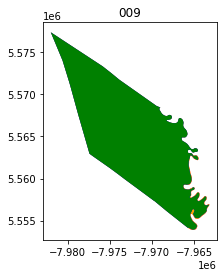

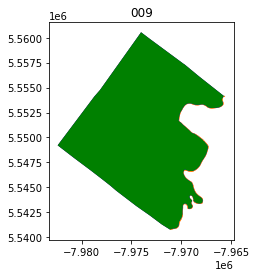

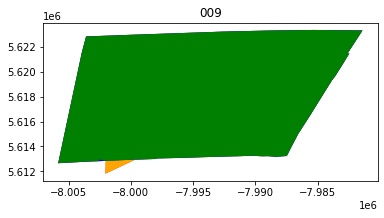

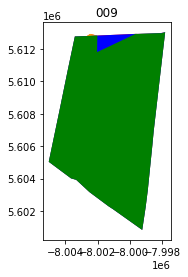

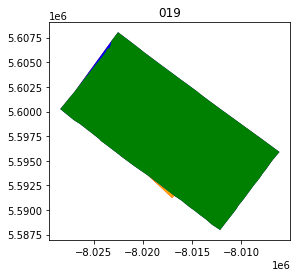

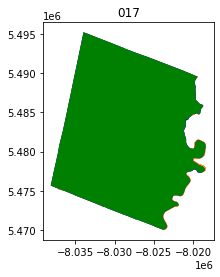

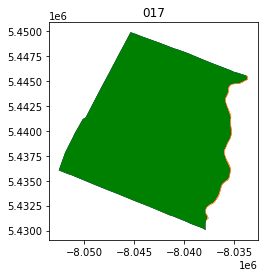

In [50]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,1]
        
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [51]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(284, 1)
0 precincts w/ a difference of 0 km^2
277 precincts w/ a difference between 0 and .1 km^2
7 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2


### Look into Warren's Gore & Norton Town Difference

Checking to see if there was a shapefile processing error on our end, and this does not seem to be the case.

<AxesSubplot:>

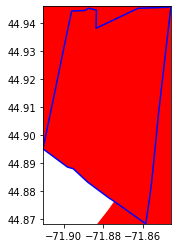

In [52]:
ax = state_distr[state_distr["NAME"]=="Essex-Caledonia-Orleans"].plot(color="red")
limits = county_sub[county_sub["NAME10"]=="Warren's"].total_bounds
xlim = ([limits[0],limits[2]])
ylim = ([limits[1],limits[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
county_sub[county_sub["NAME10"]=="Warren's"].exterior.plot(ax=ax,color="blue")

<AxesSubplot:>

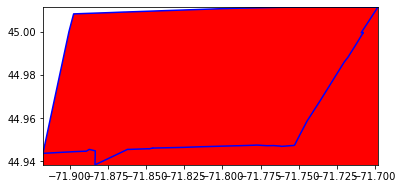

In [53]:
ax = state_distr[state_distr["NAME"]=="Essex-Caledonia-Orleans"].plot(color="red")
limits = county_sub[county_sub["NAME10"]=="Norton"].total_bounds
xlim = ([limits[0],limits[2]])
ylim = ([limits[1],limits[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
county_sub[county_sub["NAME10"]=="Norton"].exterior.plot(ax=ax,color="blue")